In [12]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

time = (torch.load('data/price_data/hours.pt'))
prices = torch.load('data/price_data/pricesDK1DK2.pt')
production = (torch.load('data/price_data/production.pt'))
temperature = (torch.load('data/price_data/temperature.pt'))

array = np.concatenate((time, production, temperature, prices), axis=1)
#array_notemp = np.concatenate((time, production, prices), axis=1)
#array_onlytime = np.concatenate((time, prices), axis=1)
#array_time_wind = np.concatenate((time, production, prices), axis=1)
#array_norad = np.concatenate((time, production, temperature, prices), axis=1)
#array_time_temp = np.concatenate((time, temperature, prices), axis=1)

#Remove all nan values:
array = array[~np.isnan(array).any(axis=1)]
torch_array = torch.tensor(array).float()
features = torch_array[:,:-2].permute(1,0)
target = torch_array[:,-2:].permute(1,0)

In [13]:
class TimeseriesDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, seq_len):
        self.seq_len = seq_len
        remainder = len(y[0,:]) % seq_len
        self.X = X[:, 0 : len(y[0,:]) - remainder]
        self.y = y[:, 0 : len(y[0,:]) - remainder]
        print(self.y[0,:])

    def __len__(self):
        return len(self.y[0,:]) - self.seq_len

    def __getitem__(self, index):
        start_index = index
        end_index = start_index + self.seq_len

        return (
            self.X[:, start_index:end_index],
            self.y[:, end_index],
        )

In [14]:
from torch.utils.data import random_split

dataset = TimeseriesDataset(features, target, seq_len=24)

TEST_SPLIT = 0.025
VALID_SPLIT = 0.05

test_size = int(len(dataset) * TEST_SPLIT)
valid_size = int(len(dataset) * VALID_SPLIT)
train_size = len(dataset) - test_size - valid_size
train_data, valid_data, test_data = random_split(
    dataset, [train_size, valid_size, test_size]
)

train_loader = torch.utils.data.DataLoader(train_data, batch_size = 64, shuffle = True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size = 64, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 64, shuffle = True)


tensor([ 372.1700,  737.5000, 1004.4300,  ..., 1868.4800, 1799.9800,
        1718.9800])


Epoch 1/500, Train Loss: 948.8891, Valid Loss: 775.0971
Epoch 2/500, Train Loss: 671.3827, Valid Loss: 722.1332
Epoch 3/500, Train Loss: 598.6114, Valid Loss: 663.2025
Epoch 4/500, Train Loss: 509.9631, Valid Loss: 557.8998
Epoch 5/500, Train Loss: 459.0175, Valid Loss: 492.9067
Epoch 6/500, Train Loss: 421.9149, Valid Loss: 439.7932
Epoch 7/500, Train Loss: 426.9843, Valid Loss: 491.6312
Epoch 8/500, Train Loss: 386.8590, Valid Loss: 413.7831
Epoch 9/500, Train Loss: 367.7658, Valid Loss: 369.3448
Epoch 10/500, Train Loss: 331.9682, Valid Loss: 431.1506
Epoch 11/500, Train Loss: 326.7085, Valid Loss: 349.5565
Epoch 12/500, Train Loss: 334.7210, Valid Loss: 314.7423
Epoch 13/500, Train Loss: 288.1686, Valid Loss: 345.7589
Epoch 14/500, Train Loss: 284.3907, Valid Loss: 308.9801
Epoch 15/500, Train Loss: 298.0896, Valid Loss: 407.6040
Epoch 16/500, Train Loss: 275.7033, Valid Loss: 312.7441
Epoch 17/500, Train Loss: 260.1756, Valid Loss: 309.8931
Epoch 18/500, Train Loss: 277.4105, Vali

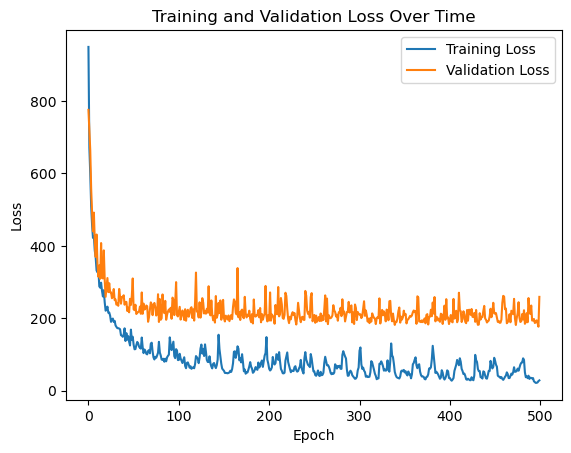

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import math

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=161, out_channels=64, kernel_size=9, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=3, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512, 64)  # 16 channels, each reduced by max pooling with kernel size 2
        self.fc2 = nn.Linear(64, 2)  # Output layer with a single neuron for continuous output

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


model = SimpleCNN()
criterion = nn.MSELoss()  # Mean Squared Error loss for regression task
criterion_nonmean = nn.MSELoss(reduction="none") #Mean is removed
optimizer = optim.Adam(model.parameters(), lr=0.01)

epochs = 500
train_losses = []
valid_losses = []

for epoch in range(epochs):
    # Training
    model.train()
    total_train_loss = 0.0

    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    average_train_loss = math.sqrt(total_train_loss / len(train_loader))
    train_losses.append(average_train_loss)

    # Validation
    model.eval()
    total_valid_loss = 0.0

    with torch.no_grad():
        for inputs, targets in valid_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_valid_loss += loss.item()

    average_valid_loss = math.sqrt(total_valid_loss / len(valid_loader))
    valid_losses.append(average_valid_loss)

    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {average_train_loss:.4f}, Valid Loss: {average_valid_loss:.4f}')

# Plot training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.savefig("loss_plot.pdf", format="pdf", bbox_inches="tight")
plt.show()


In [16]:
# Evaluate on the test set
model.eval()
total_test_loss = []
total_outputs = []
total_targets = []
percentage_error = []

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        loss = criterion_nonmean(outputs, targets)
        loss = torch.sqrt(loss)
        total_test_loss.append(loss)
        total_outputs.append(outputs)
        total_targets.append(targets)

average_test_loss = sum([torch.mean(val) for val in total_test_loss]) / len(test_loader)
print(f'Test Loss: {average_test_loss:.4f}')


Test Loss: 141.9534


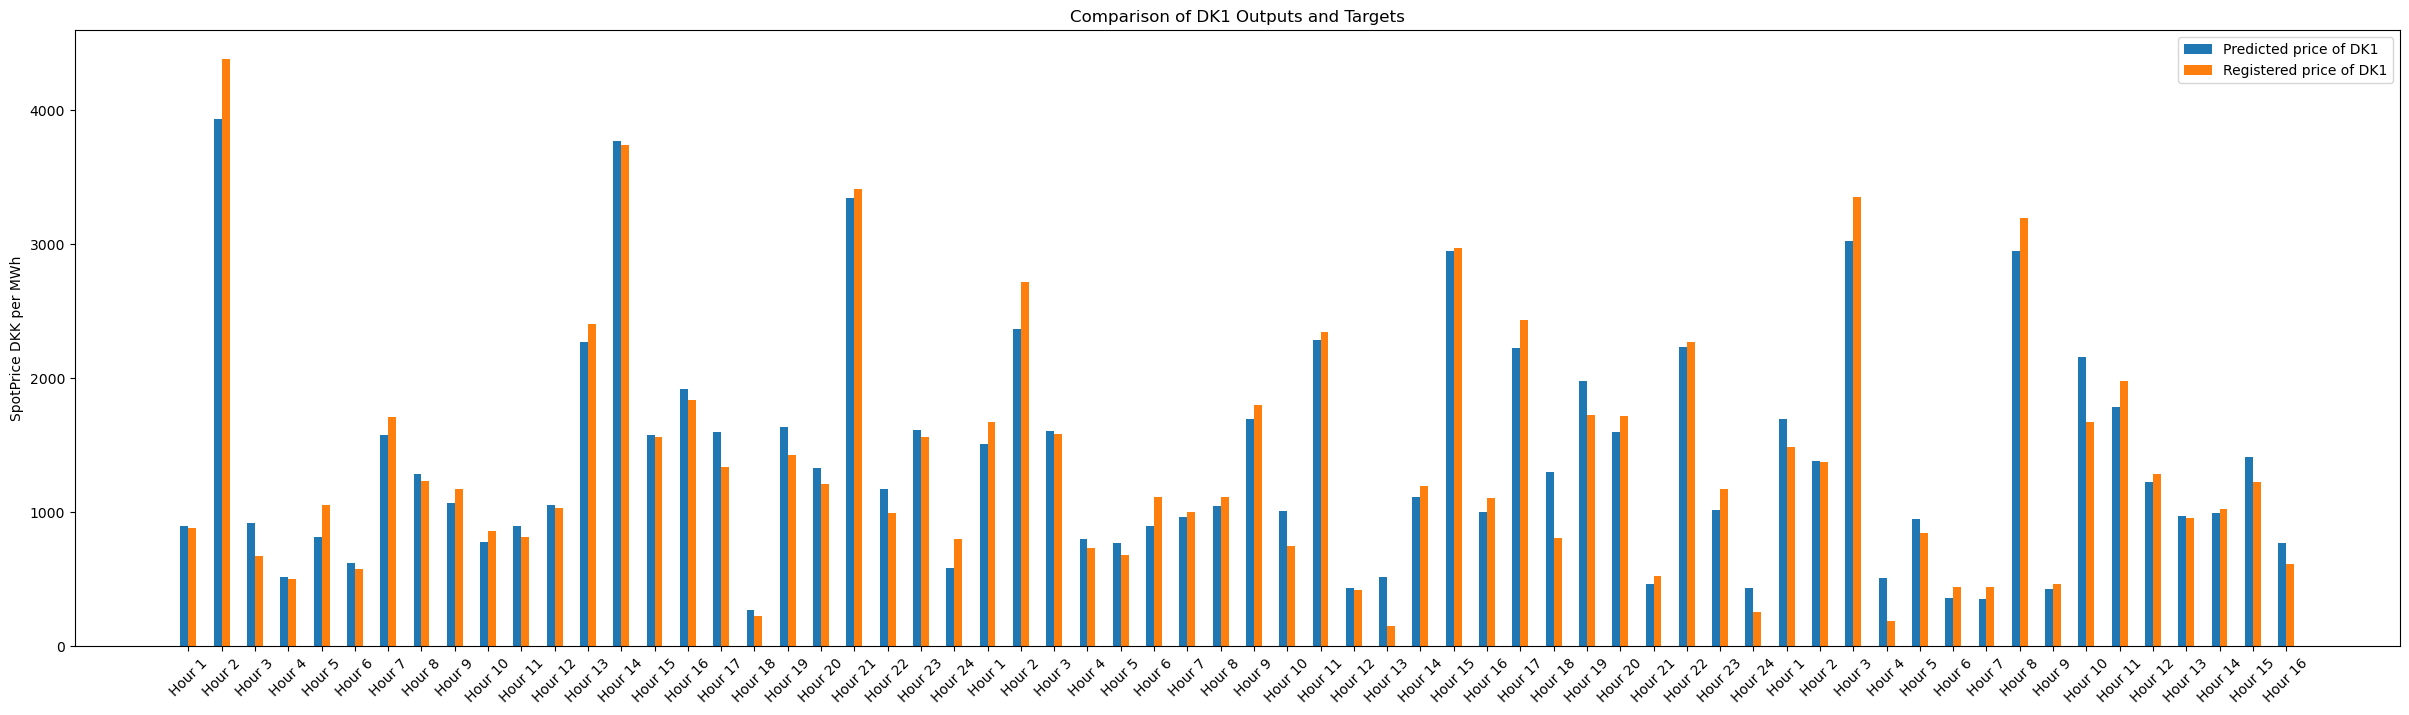

In [18]:


# Bar width and positions
width = 0.5
spacing = 0.1
positions = np.arange(64) * (width * 4 + spacing)

# Plotting
fig, ax = plt.subplots(figsize=(30, 8))

# Plot bars for DK1
bars_dk1_output = ax.bar(positions - width / 2, total_outputs[0][:, 0], width, label='Predicted price of DK1')
bars_dk1_target = ax.bar(positions + width / 2, total_targets[0][:, 0], width, label='Registered price of DK1')

hours = [(i % 24) + 1 for i in range(64)]

ax.set_ylabel('SpotPrice DKK per MWh')
ax.set_title('Comparison of DK1 Outputs and Targets')
ax.set_xticks(positions)
ax.set_xticklabels([f'Hour {i}' for i in hours], rotation=45)
ax.legend()
